<a href="https://colab.research.google.com/github/V4YLO/League-of-Legends-Match-Predictor/blob/main/LoLMatchPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving league_of_legends_data_large.csv to league_of_legends_data_large (1).csv
Epoch 100/1000, Loss: 0.7154
Epoch 200/1000, Loss: 0.7039
Epoch 300/1000, Loss: 0.6967
Epoch 400/1000, Loss: 0.6923
Epoch 500/1000, Loss: 0.6896
Epoch 600/1000, Loss: 0.6879
Epoch 700/1000, Loss: 0.6869
Epoch 800/1000, Loss: 0.6863
Epoch 900/1000, Loss: 0.6859
Epoch 1000/1000, Loss: 0.6856
Training Accuracy: 0.5437
Test Accuracy: 0.5100
Training Accuracy (L2): 0.5575
Test Accuracy (L2): 0.5350


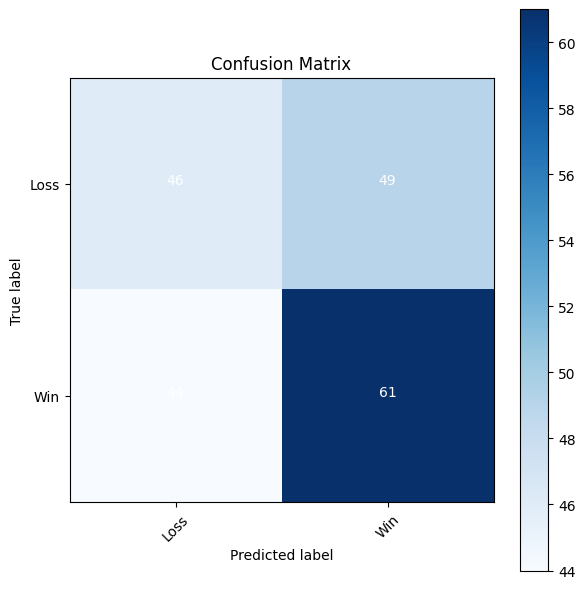

Classification Report:
               precision    recall  f1-score   support

         0.0       0.51      0.48      0.50        95
         1.0       0.55      0.58      0.57       105

    accuracy                           0.54       200
   macro avg       0.53      0.53      0.53       200
weighted avg       0.53      0.54      0.53       200



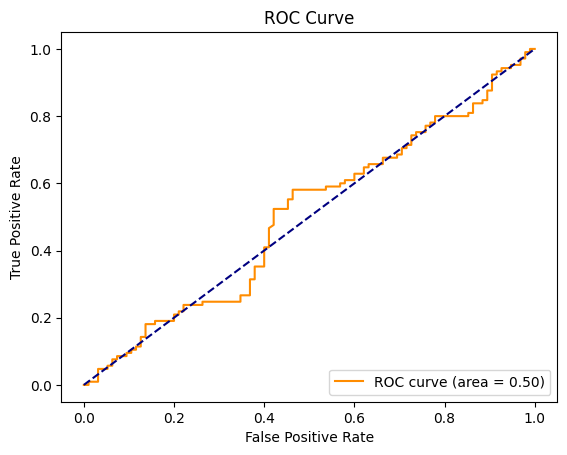

Loaded Model Test Accuracy: 0.5350
LR=0.01, Test Accuracy=0.4850
LR=0.05, Test Accuracy=0.5250
LR=0.1, Test Accuracy=0.4850
Best Learning Rate: 0.05, Accuracy: 0.5250
        Feature  Importance
3   gold_earned    0.139206
0         kills    0.112409
5  wards_placed    0.104161
6  wards_killed   -0.047183
4            cs    0.011408
1        deaths    0.010283
2       assists    0.004646
7  damage_dealt    0.003004


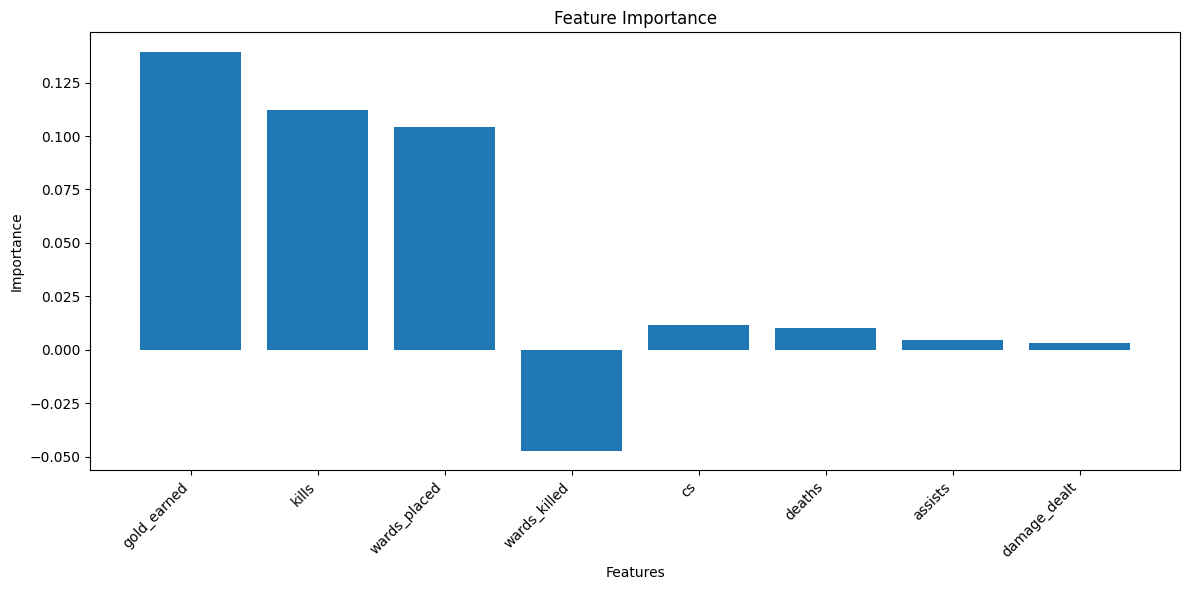

In [6]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import files
uploaded = files.upload()
data = pd.read_csv('league_of_legends_data_large.csv')
X = data.drop('win', axis=1)
y = data['win']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

import torch.nn as nn
import torch.optim as optim

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

input_dim = X_train_tensor.shape[1]
model = LogisticRegressionModel(input_dim)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

epochs = 1000

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')


model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor)
    y_pred_test = model(X_test_tensor)

train_acc = ((y_pred_train > 0.5).float() == y_train_tensor).float().mean()
test_acc = ((y_pred_test > 0.5).float() == y_test_tensor).float().mean()
print(f'Training Accuracy: {train_acc.item():.4f}')
print(f'Test Accuracy: {test_acc.item():.4f}')

model = LogisticRegressionModel(input_dim)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor)
    y_pred_test = model(X_test_tensor)

train_acc = ((y_pred_train > 0.5).float() == y_train_tensor).float().mean()
test_acc = ((y_pred_test > 0.5).float() == y_test_tensor).float().mean()
print(f'Training Accuracy (L2): {train_acc.item():.4f}')
print(f'Test Accuracy (L2): {test_acc.item():.4f}')

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import itertools
y_pred_test_labels = (y_pred_test > 0.5).float()
cm = confusion_matrix(y_test_tensor.numpy(), y_pred_test_labels.numpy())
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = range(2)
plt.xticks(tick_marks, ['Loss', 'Win'], rotation=45)
plt.yticks(tick_marks, ['Loss', 'Win'])

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], ha="center", color="white" if cm[i, j] > cm.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print("Classification Report:\n", classification_report(y_test_tensor.numpy(), y_pred_test_labels.numpy()))
fpr, tpr, _ = roc_curve(y_test_tensor.numpy(), y_pred_test.numpy())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

torch.save(model.state_dict(), 'lol_model.pth')

loaded_model = LogisticRegressionModel(input_dim)
loaded_model.load_state_dict(torch.load('lol_model.pth'))
loaded_model.eval()

with torch.no_grad():
    y_pred_loaded = loaded_model(X_test_tensor)
    loaded_acc = ((y_pred_loaded > 0.5).float() == y_test_tensor).float().mean()

print(f"Loaded Model Test Accuracy: {loaded_acc.item():.4f}")

learning_rates = [0.01, 0.05, 0.1]
best_acc = 0
best_lr = 0

for lr in learning_rates:
    model = LogisticRegressionModel(input_dim)
    optimizer = optim.SGD(model.parameters(), lr=lr)

    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(X_test_tensor)
        acc = ((preds > 0.5).float() == y_test_tensor).float().mean().item()
        print(f"LR={lr}, Test Accuracy={acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_lr = lr

print(f"Best Learning Rate: {best_lr}, Accuracy: {best_acc:.4f}")

weights = model.linear.weight.data.numpy().flatten()
features = X.columns

feature_importance = pd.DataFrame({'Feature': features, 'Importance': weights})
feature_importance = feature_importance.reindex(feature_importance.Importance.abs().sort_values(ascending=False).index)

print(feature_importance)

plt.figure(figsize=(12, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xticks(rotation=45, ha='right')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.tight_layout()
plt.show()